Predicción de Precios de Vehículos Usados (Core)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  1. Carga y Exploración de Datos:

In [3]:
# cargar el dataset automobile data
data = pd.read_csv('../data/uvehicles.csv', nrows=100000)
print(data.shape)
print(data.columns)
data.info()
data.head(5)

(100000, 26)
Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            100000 non-null  int64  
 1   url           100000 non-null  object 
 2   region        100000 non-null  object 
 3   region_url    100000 non-null  object 
 4   price         100000 non-null  int64  
 5   year          99572 non-null   float64
 6   manufacturer  95580 non-null   object 
 7   model         98715 non-null   object 
 8   condition     61711 non-null   object 
 9   cylinders     59841 non-null   object 
 10  fuel

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
print("Nulos: ", data.isnull().sum())
print("Duplicados: ", data.duplicated().sum())


Nulos:  id                   0
url                  0
region               0
region_url           0
price                0
year               428
manufacturer      4420
model             1285
condition        38289
cylinders        40159
fuel               603
odometer          1521
title_status      2279
transmission       514
VIN              36038
drive            30474
size             72154
type             19611
paint_color      29776
image_url           38
description         39
county          100000
state                0
lat                539
long               539
posting_date        38
dtype: int64
Duplicados:  0


In [94]:
data[['price', 'odometer']].describe()

,price,odometer
count,1.000000e+05,9.847900e+04
mean,1.110640e+05,9.644995e+04
std,1.471778e+07,2.323362e+05
min,0.000000e+00,0.000000e+00
25%,5.999000e+03,3.665700e+04
50%,1.399500e+04,8.254300e+04
75%,2.599000e+04,1.300000e+05
max,3.024942e+09,1.000000e+07


#  2. Limpieza y Preprocesamiento:
Para optimizar el proceso solo tomaremos las columnas que se cree son las mas relevantes

## Limpieza

In [5]:
# Eliminar columnas innesecarias de manera permanente
data.drop(columns=['region', 'region_url', 'url', 'image_url', 'county'], inplace=True)

# Verificar el resultado
print(data.columns)

Index(['id', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'description', 'state', 'lat',
       'long', 'posting_date'],
      dtype='object')


In [6]:
# Definir las columnas en las que deseas eliminar filas con valores nulos
nan_delete = ['year', 'manufacturer', 'title_status', 'odometer', 'fuel']

# Eliminar las filas con valores nulos en las columnas especificadas
data = data.dropna(subset=nan_delete)

# Verificar el resultado
print(data.isnull().sum()) 

# Corregimos los tipo de datos
data_type = {
    'manufacturer' : 'category',
    'title_status' : 'category',
    'fuel' : 'category'    
}
data = data.astype(data_type)
print(data.isnull().sum())


id                  0
price               0
year                0
manufacturer        0
model            1241
condition       35301
cylinders       37271
fuel                0
odometer            0
title_status        0
transmission      313
VIN             32757
drive           26960
size            65609
type            17842
paint_color     25903
description         1
state               0
lat               471
long              471
posting_date        0
dtype: int64
id                  0
price               0
year                0
manufacturer        0
model            1241
condition       35301
cylinders       37271
fuel                0
odometer            0
title_status        0
transmission      313
VIN             32757
drive           26960
size            65609
type            17842
paint_color     25903
description         1
state               0
lat               471
long              471
posting_date        0
dtype: int64


In [118]:
data[['year', 'odometer']].describe()

,year,odometer
count,91685.000000,9.168500e+04
mean,2011.154725,9.621448e+04
std,9.595501,2.298753e+05
min,1900.000000,0.000000e+00
25%,2008.000000,3.733400e+04
50%,2014.000000,8.300000e+04
75%,2017.000000,1.300000e+05
max,2022.000000,1.000000e+07


### correccion de outliers

In [7]:
# Filtrar los datos donde year sea menor a 1910
old = data[data['year'] < 1910][['year', 'title_status', 'price']]

# Ver los resultados
print(old)

         year title_status  price
42454  1900.0        clean  38250
94319  1900.0        clean      1
95914  1900.0        clean      1
96564  1900.0        clean      1


In [8]:
data = data[(data['year'] >= 1910)]

In [9]:
# Filtrar los datos donde 'odometer' es mayor a un millón
odometer_above_500k = data[data['odometer'] > 500000][['odometer', 'year']]

# Ver los resultados
print(odometer_above_500k)


        odometer    year
280     999999.0  1960.0
455    9999999.0  1929.0
562    2222222.0  2014.0
615    1111111.0  2014.0
616    1111111.0  2018.0
...          ...     ...
97847  9999999.0  1956.0
97923   780000.0  2012.0
98458   771000.0  2012.0
99715  1111111.0  1999.0
99883   999999.0  2009.0

[203 rows x 2 columns]


In [10]:
# Filtrar los datos donde 'odometer' es menor a 5, se asume que son autos usados por lo que si exiten muchos con muy poco kilometraje
# se los tomara como errores al cargar los datos
odometer_min = data[data['odometer'] < 5][['odometer', 'year']]

# Ver los resultados
print(odometer_min)

       odometer    year
563         0.0  2006.0
889         0.0  2006.0
985         0.0  2011.0
1192        0.0  2016.0
1195        0.0  2014.0
...         ...     ...
98963       0.0  2016.0
99008       1.0  2013.0
99320       1.0  2013.0
99512       1.0  2013.0
99634       1.0  2013.0

[716 rows x 2 columns]


In [11]:
# Se decide eliminar todos los registros con odometer > 500000
data = data[(data['odometer'] >= 5) & (data['odometer'] <= 500_000)]

In [12]:
price_over_1m = data[data['price'] > 100000][['price', 'title_status']]

# Ver los resultados
print(price_over_1m)

            price title_status
1727       130000        clean
1838     99999999        clean
2922       140000      rebuilt
4797       104000        clean
4826       104900        clean
...           ...          ...
91576  3024942282        clean
93202      199999        clean
93653      159991        clean
95119      990000        clean
98920      122420        clean

[118 rows x 2 columns]


In [ ]:
# Se decide eliminar todos los registros con price mayor a 80000 y menor a 500
data = data[(data['price'] >= 500) & (data['price'] <= 80_000)]

In [26]:
# Obtener los valores únicos de la columna 'manufacturer'
unique_manufacturers = data['manufacturer'].unique()

# Convertir a una lista y mostrar los primeros 41 elementos (o los que necesites)
print('\n'.join(str(item) for item in unique_manufacturers))

data['manufacturer'].isnull().sum()


gmc
chevrolet
toyota
ford
jeep
nissan
ram
mazda
cadillac
honda
dodge
lexus
jaguar
buick
chrysler
volvo
audi
infiniti
lincoln
alfa-romeo
subaru
acura
hyundai
mercedes-benz
bmw
mitsubishi
volkswagen
porsche
kia
rover
mini
pontiac
fiat
tesla
mercury
saturn
harley-davidson
datsun
aston-martin
land rover


0

## Escalamiento y transformacion

In [27]:
# Seleccionar características y variable objetivo
X = data[['year', 'manufacturer', 'title_status', 'odometer', 'fuel']]
y = data['price']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir las columnas categóricas y numéricas
categorical_features = ['manufacturer', 'title_status', 'fuel']
numeric_features = ['year', 'odometer', 'price']

# Crear el transformador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Crear el pipeline con el preprocesador y el modelo RandomForestRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

#  3. Exploración de Datos:

In [70]:
X.head()

,year,manufacturer,title_status,odometer,fuel
27,2014.0,gmc,clean,57923.0,gas
28,2010.0,chevrolet,clean,71229.0,gas
29,2020.0,chevrolet,clean,19160.0,gas
30,2017.0,toyota,clean,41124.0,gas
31,2013.0,ford,clean,128000.0,gas


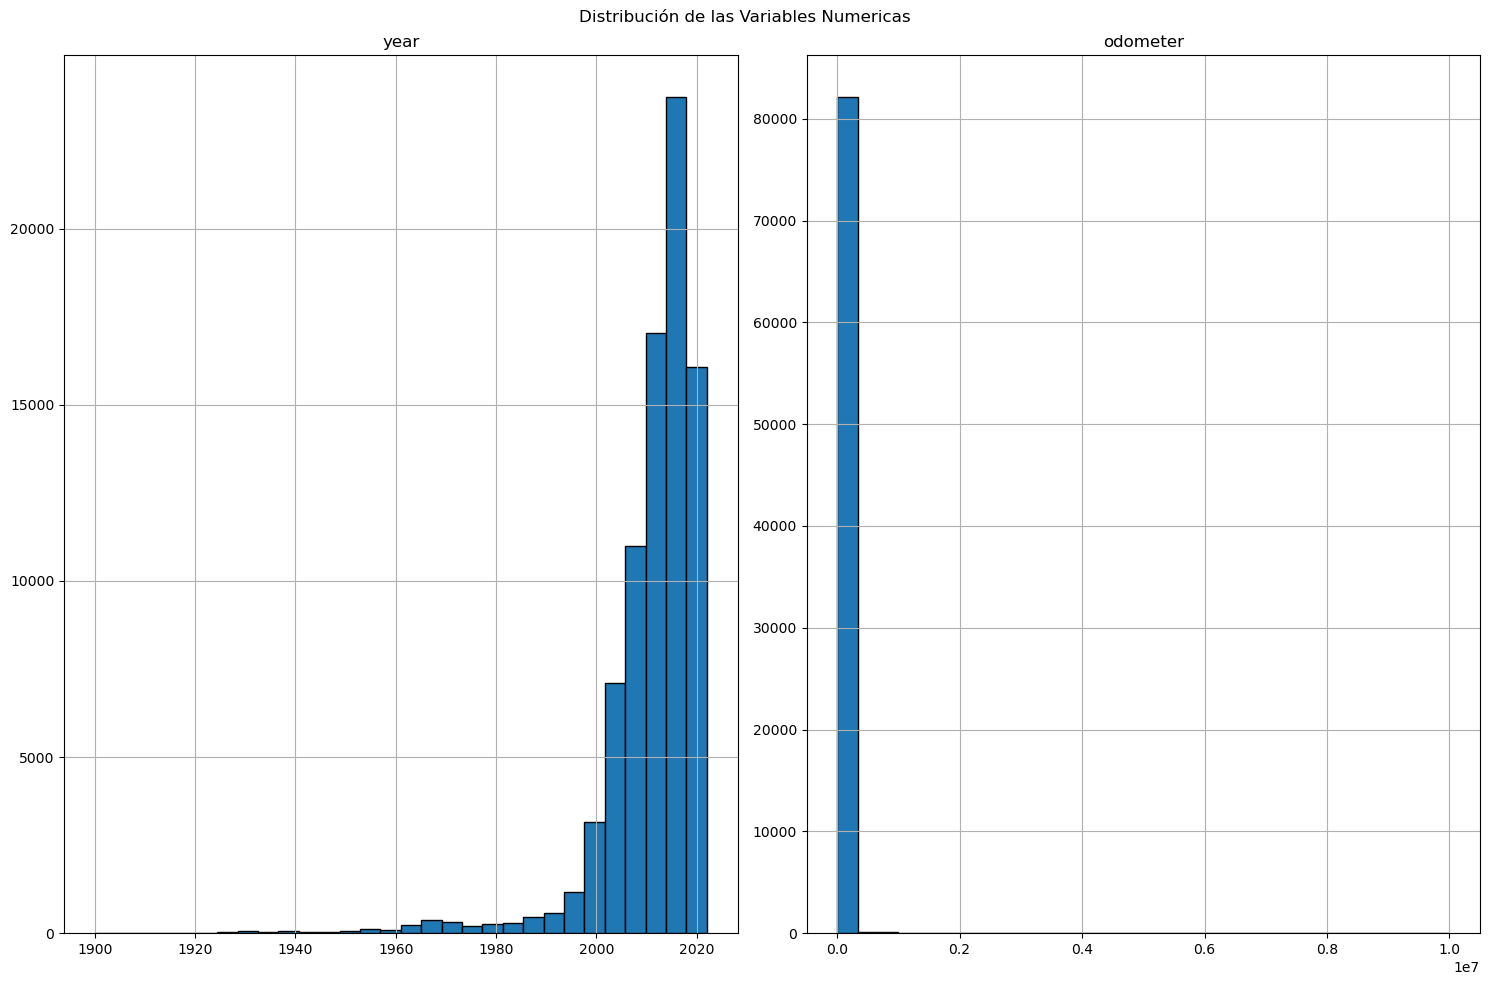

In [137]:
# Crear histogramas para cada característica
X.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Distribución de las Variables Numericas')
plt.tight_layout()
plt.show()

#  4. Modelado y Evaluación:

## Regresion lineal

In [20]:
# 1. Preparar los datos
X = data[['year', 'manufacturer', 'title_status', 'odometer', 'fuel']]
y = data['price']

# 2. Definir columnas numéricas y categóricas
numeric_features = ['year', 'odometer']
categorical_features = ['manufacturer', 'title_status', 'fuel']

# 2. Convertir las variables categóricas a variables dummy (OneHotEncoding)
X = pd.get_dummies(X, drop_first=True)  # Esto crea variables dummy para la columna 'make'

# 3. Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo (entrenarlo)
model.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
lmae = mean_absolute_error(y_test, y_pred)
lmse = mean_squared_error(y_test, y_pred)
lr2 = r2_score(y_test, y_pred)

# Imprimir los resultados
print(f"Mean Absolute Error (MAE): {lmae:.2f}")
print(f"Mean Squared Error (MSE): {lmse:.2f}")
print(f"R-squared (R²): {lr2:.2f}")


Mean Absolute Error (MAE): 6799.33
Mean Squared Error (MSE): 92188490.36
R-squared (R²): 0.53


## Random Forest Regressor

In [28]:
X = data[['year', 'manufacturer', 'title_status', 'odometer', 'fuel']]
y = data['price']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir las columnas categóricas y numéricas
categorical_features = ['manufacturer', 'title_status', 'fuel']
numeric_features = ['year', 'odometer']

# Crear el transformador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Crear el pipeline con el preprocesador y el modelo RandomForestRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 5. Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Entrenar el modelo
model.fit(X_train, y_train)

# 7. Hacer predicciones
y_pred = model.predict(X_test)

# 8. Evaluar el modelo
kmae = mean_absolute_error(y_test, y_pred)
kmse = mean_squared_error(y_test, y_pred)
kr2 = r2_score(y_test, y_pred)

# 9. Imprimir los resultados
print(f"Mean Absolute Error (MAE): {kmae:.2f}")
print(f"Mean Squared Error (MSE): {kmse:.2f}")
print(f"R-squared (R²): {kr2:.2f}")


Mean Absolute Error (MAE): 3426.27
Mean Squared Error (MSE): 38752110.11
R-squared (R²): 0.79


#  5. Optimización del Modelo: (no me salio)

In [ ]:
# Definir las columnas categóricas y numéricas
categorical_features = ['manufacturer', 'title_status', 'fuel']
numeric_features = ['year', 'odometer']

# Crear el transformador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Crear el pipeline con el preprocesador y el modelo RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10,],
    'regressor__min_samples_split': [2, 5]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # Número de folds en la validación cruzada
    scoring='neg_mean_absolute_error',  # Métrica a optimizar
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar el proceso
)

# Ajustar GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y el rendimiento obtenido
print("Best Parameters:", grid_search.best_params_)
print("Best Score (neg MAE):", -grid_search.best_score_)  # Cambia el signo para obtener MAE positivo

In [ ]:


# Evaluar el modelo con el mejor conjunto de hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

#  6. Documentación y Entrega:
El Random Forest Regressor fue el modelo que arrojo el mejor resultado, aunque el porcentaje es mejorable, esto se debe principalmente a la falta de datos
en columnas determinantes como los que determinan el tipo de motor de los vehiculos, el tipo de vehiculo o el modelo.
Apesar de eso el r2 que se obtuvo es de 0.79

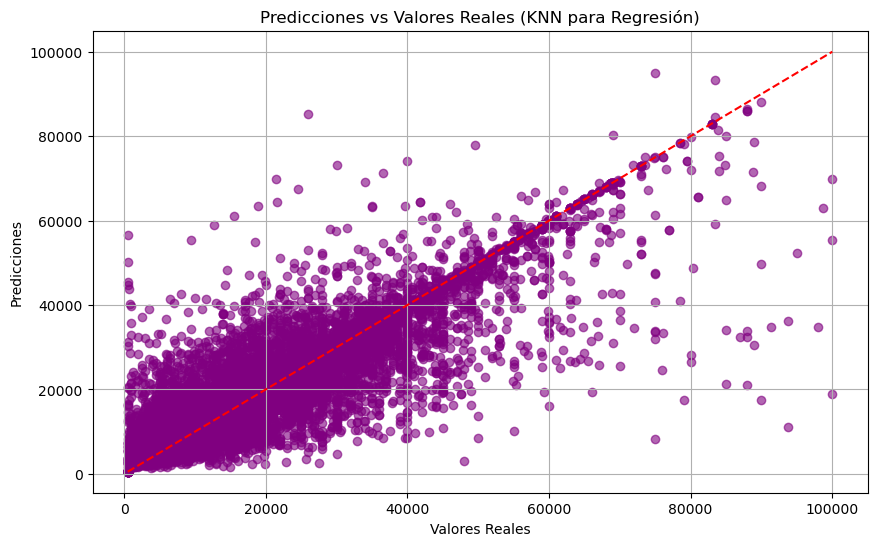

In [ ]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Random Forest Regressor)')
plt.grid()
plt.show()


En el grafico de arriba se puede observar la relacion entre las predicciones y los valores reales, y tambien se puede observar bastante dispersion
lo cual es normal en un dataset donde se tienen datos de autos usados y existen demasiados detalles a tener en cuenta para poder predecir el precio
